Import Library 

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch


TSP Enviroment 

In [48]:
class TSPEnvironment:
    def __init__(self, num_cities=20):
        self.num_cities = num_cities
        self.cities = np.random.rand(num_cities, 2) * 100
        self.distance_matrix = self.compute_distance_matrix()
        self.reset()

    def compute_distance_matrix(self):
        dist_matrix = np.zeros((self.num_cities, self.num_cities))
        for i in range(self.num_cities):
            for j in range(self.num_cities):
                dist_matrix[i, j] = np.linalg.norm(self.cities[i] - self.cities[j])
        return dist_matrix

    def reset(self):
        self.visited = set()
        self.current_city = np.random.randint(0, self.num_cities)
        self.visited.add(self.current_city)
        self.available_cities = set(range(self.num_cities)) - self.visited
        self.total_distance = 0
        return self.get_normalized_state()  # Using normalized state

    def get_normalized_state(self):
        # Normalize city coordinates to [0,1]
        normalized_cities = self.cities / 100.0
        
        # Create visited vector
        visited_vector = np.array([1 if i in self.visited else 0 for i in range(self.num_cities)])
        
        # Add last 3 visited cities (normalized indices)
        last_visited = list(self.visited)[-3:] if len(self.visited) >= 3 else [-1, -1, -1]
        last_visited += [-1] * (3 - len(last_visited))
        normalized_last_visited = [x/self.num_cities if x != -1 else 0 for x in last_visited]
        
        return np.concatenate((normalized_cities.flatten(), visited_vector, normalized_last_visited)).tolist()

    def step(self, action):
        if action not in self.available_cities:
            return self.get_normalized_state(), -1.0, False  # Normalized penalty

        distance = self.distance_matrix[self.current_city, action]
        self.total_distance += distance
        self.current_city = action
        self.visited.add(action)
        self.available_cities.remove(action)

        done = len(self.visited) == self.num_cities

        # Normalized reward between [0,1]
        reward = -distance / 100.0  # Negative reward proportional to distance
        
        if done:
            # Add completion bonus based on total path efficiency
            normalized_total = self.total_distance / (100.0 * self.num_cities)
            reward += 2.0 * (1.0 - normalized_total)  # Bonus for shorter total paths

        return self.get_normalized_state(), reward, done

    def get_total_distance(self):
        return self.total_distance

class StabilizedActorNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_size, hidden_size*2),
            nn.LayerNorm(hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
        # Initialize weights
        for layer in self.actor.modules():
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
                nn.init.constant_(layer.bias, 0.0)

    def forward(self, state):
        return self.actor(state)

class StabilizedCriticNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.critic = nn.Sequential(
            nn.Linear(input_size, hidden_size*2),
            nn.LayerNorm(hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        # Initialize weights
        for layer in self.critic.modules():
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
                nn.init.constant_(layer.bias, 0.0)

    def forward(self, state):
        return self.critic(state)

class StabilizedActorCriticTSP:
    def __init__(self, num_cities, hidden_size=128):
        self.num_cities = num_cities
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        input_size = num_cities * 2 + num_cities + 3
        
        self.actor = StabilizedActorNetwork(input_size, hidden_size, num_cities).to(self.device)
        self.critic = StabilizedCriticNetwork(input_size, hidden_size).to(self.device)
        
        # Smaller learning rates for stability
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.0003)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.0003)
        
        # Simple learning rate decay
        self.actor_scheduler = optim.lr_scheduler.StepLR(self.actor_optimizer, step_size=1000, gamma=0.95)
        self.critic_scheduler = optim.lr_scheduler.StepLR(self.critic_optimizer, step_size=1000, gamma=0.95)

    def select_action(self, state, available_cities, temperature=1.0):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(self.device)
            logits = self.actor(state_tensor)
            
            # Mask unavailable actions
            mask = torch.zeros_like(logits)
            mask[list(available_cities)] = 1
            masked_logits = logits * mask - 1e9 * (1 - mask)
            
            # Apply temperature scaling
            probs = torch.softmax(masked_logits / temperature, dim=-1)
            
            # Add small exploration noise
            if temperature > 0.5:  # Only add noise during training
                noise = torch.randn_like(probs) * 0.05 * temperature
                probs = torch.softmax(masked_logits / temperature + noise, dim=-1)
            
            probs = torch.clamp(probs, min=1e-8)
            probs = probs / probs.sum()
            
            action = Categorical(probs).sample()
            return action.item()

    def calculate_returns(self, rewards, gamma=0.99):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.FloatTensor(returns).to(self.device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

    def update(self, states, actions, rewards):
        states_tensor = torch.FloatTensor(states).to(self.device)
        actions_tensor = torch.LongTensor(actions).to(self.device)
        returns = self.calculate_returns(rewards)
        
        # Critic update
        value_pred = self.critic(states_tensor).squeeze()
        critic_loss = nn.MSELoss()(value_pred, returns)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
        self.critic_optimizer.step()
        
        # Actor update
        advantages = returns - value_pred.detach()
        
        logits = self.actor(states_tensor)
        probs = torch.softmax(logits, dim=-1)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions_tensor)
        
        actor_loss = -(log_probs * advantages).mean()
        
        # Add entropy regularization
        entropy = dist.entropy().mean()
        actor_loss -= 0.01 * entropy
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
        self.actor_optimizer.step()
        
        return actor_loss.item(), critic_loss.item()

def evaluate(env, agent, num_episodes=100):
    total_distances = []
    total_times = []

    for episode in range(num_episodes):
        start_time = time.time()
        state = env.reset()
        done = False

        while not done:
            action = agent.select_action(state, env.available_cities, temperature=0.1)
            next_state, reward, done = env.step(action)
            state = next_state

        total_distances.append(env.get_total_distance())
        total_times.append(time.time() - start_time)

    avg_distance = np.mean(total_distances)
    best_distance = np.min(total_distances)
    avg_time = np.mean(total_times)

    print(f"Evaluation Results:\n"
          f"Avg Distance: {avg_distance:.2f}\n"
          f"Best Distance: {best_distance:.2f}\n"
          f"Avg Time per Episode: {avg_time:.2f} sec")

    return avg_distance, best_distance, avg_time

def train(env, agent, num_episodes=100000, eval_interval=1000):
    best_distance = float('inf')
    best_episode = 0
    temperature = 1.0  # Start with lower temperature
    
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        states, actions, rewards = [], [], []
        
        while not done:
            action = agent.select_action(state, env.available_cities, temperature)
            next_state, reward, done = env.step(action)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            
            state = next_state
        
        # Update policy
        actor_loss, critic_loss = agent.update(states, actions, rewards)
        
        # Update temperature using a more stable schedule
        temperature = max(0.5, 1.0 * np.exp(-episode / 2000))
        
        # Track best performance
        total_distance = env.get_total_distance()
        if total_distance < best_distance:
            best_distance = total_distance
            best_episode = episode
            
            # Save best model
            torch.save({
                'actor_state_dict': agent.actor.state_dict(),
                'critic_state_dict': agent.critic.state_dict(),
                'best_distance': best_distance,
            }, 'best_tsp_model.pth')
        
        # Update learning rates
        agent.actor_scheduler.step()
        agent.critic_scheduler.step()
        
        if episode % eval_interval == 0:
            print(f"Episode {episode}, Actor Loss: {actor_loss:.4f}, "
                  f"Critic Loss: {critic_loss:.4f}, Best Distance: {best_distance:.2f}, "
                  f"Temperature: {temperature:.2f}")

if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Initialize environment and agent
    env = TSPEnvironment(num_cities=20)
    agent = StabilizedActorCriticTSP(num_cities=20)
    
    # Training
    print("Starting training...")
    train(env, agent)
    
    # Final evaluation
    print("\n===== Final Actor-Critic Evaluation =====")
    ac_avg, ac_best, ac_time = evaluate(env, agent)
    
    # Random baseline comparison
    print("\n===== Random Baseline =====")
    random_agent = StabilizedActorCriticTSP(num_cities=20)
    rand_avg, rand_best, rand_time = evaluate(env, random_agent)
    
    # Print final comparison
    print("\n===== Final Results =====")
    print(f"Actor-Critic: Best={ac_best:.2f}, Avg={ac_avg:.2f}, Time={ac_time:.2f}s")
    print(f"Random Baseline: Best={rand_best:.2f}, Avg={rand_avg:.2f}, Time={rand_time:.2f}s")

Starting training...
Episode 0, Actor Loss: -5.6895, Critic Loss: 4.4560, Best Distance: 1044.07, Temperature: 1.00
Episode 1000, Actor Loss: -0.2772, Critic Loss: 0.0130, Best Distance: 576.11, Temperature: 0.61
Episode 2000, Actor Loss: 0.0989, Critic Loss: 0.0058, Best Distance: 576.11, Temperature: 0.50
Episode 3000, Actor Loss: 0.0273, Critic Loss: 0.0082, Best Distance: 464.47, Temperature: 0.50
Episode 4000, Actor Loss: -0.3383, Critic Loss: 0.0172, Best Distance: 464.47, Temperature: 0.50
Episode 5000, Actor Loss: -0.0633, Critic Loss: 0.0066, Best Distance: 462.47, Temperature: 0.50
Episode 6000, Actor Loss: -0.4262, Critic Loss: 0.0263, Best Distance: 430.48, Temperature: 0.50
Episode 7000, Actor Loss: -0.7338, Critic Loss: 0.0189, Best Distance: 415.43, Temperature: 0.50
Episode 8000, Actor Loss: -0.0246, Critic Loss: 0.0060, Best Distance: 407.80, Temperature: 0.50
Episode 9000, Actor Loss: 0.0308, Critic Loss: 0.0013, Best Distance: 390.47, Temperature: 0.50
Episode 10000,

Optimized TSP route 

Loaded trained model with best distance: 390.47


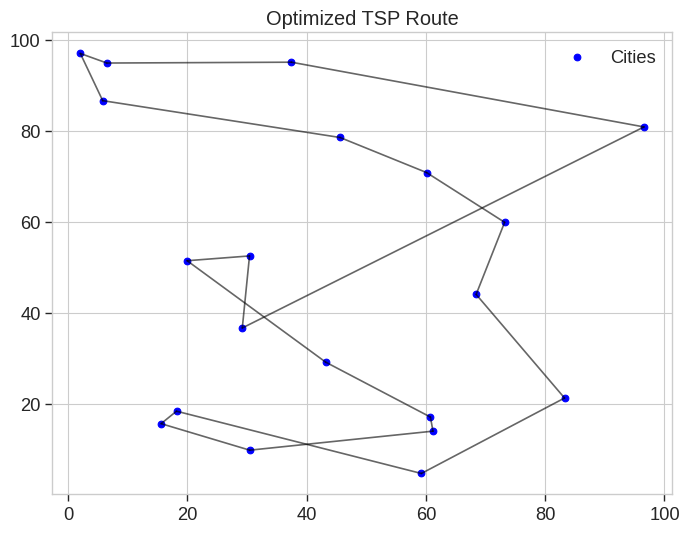

In [74]:
# Load the trained model
def load_trained_model(agent, model_path='/home/hailemicaelyimer/Desktop/Federated_Learning/best_tsp_model.pth'):
    checkpoint = torch.load(model_path, weights_only=False)  # ✅ Ensure full loading
    agent.actor.load_state_dict(checkpoint['actor_state_dict'])
    agent.critic.load_state_dict(checkpoint['critic_state_dict'])
    print(f"Loaded trained model with best distance: {checkpoint.get('best_distance', 'Unknown'):.2f}")

def plot_tsp_route(cities, route):
    plt.figure(figsize=(8, 6))
    plt.scatter(cities[:, 0], cities[:, 1], c='blue', marker='o', label='Cities')
    
    # Draw the path
    for i in range(len(route) - 1):
        start, end = route[i], route[i + 1]
        plt.plot([cities[start, 0], cities[end, 0]], [cities[start, 1], cities[end, 1]], 'k-', alpha=0.6)
    
    # Complete the loop back to the start
    plt.plot([cities[route[-1], 0], cities[route[0], 0]],
             [cities[route[-1], 1], cities[route[0], 1]], 'k-', alpha=0.6)
    
    plt.title("Optimized TSP Route")
    plt.legend()
    plt.show()

# Generate TSP solution using the trained model
def generate_tsp_solution(env, agent):
    state = env.reset()
    done = False
    route = [env.current_city]
    
    while not done:
        action = agent.select_action(state, env.available_cities, temperature=0.1)
        next_state, reward, done = env.step(action)
        route.append(action)
        state = next_state
    
    return route

if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Initialize environment and agent
    env = TSPEnvironment(num_cities=20)
    agent = StabilizedActorCriticTSP(num_cities=20)
    
    # Load the trained model
    load_trained_model(agent)
    
    # Generate a solution and plot it
    tsp_route = generate_tsp_solution(env, agent)
    plot_tsp_route(env.cities, tsp_route)


Convergence of Best Tour Distance During Training

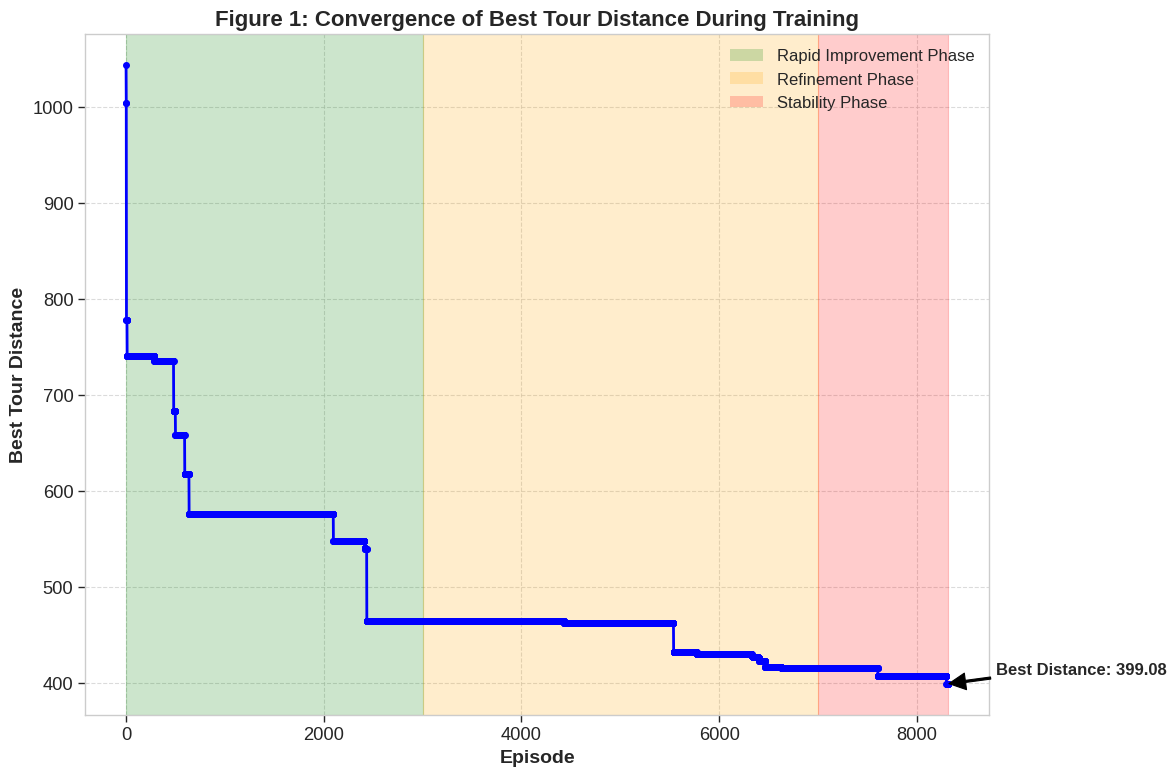

In [76]:
# Load checkpoint
checkpoint_path = "best_tsp_model.pth"

try:
    checkpoint = torch.load(checkpoint_path, weights_only=False)
except FileNotFoundError:
    print(f"Error: Checkpoint file '{checkpoint_path}' not found.")
    exit()

# Extract training logs
if "training_log" in checkpoint:
    df = pd.DataFrame(checkpoint["training_log"])  # Convert log to DataFrame

    # Plot convergence of best tour distance
    plt.figure(figsize=(12, 8))
    plt.plot(df['episode'], df['best_distance'], 'o-', color='blue', linewidth=2, markersize=4)

    # Labels and title
    plt.xlabel('Episode', fontweight='bold', fontsize=14)
    plt.ylabel('Best Tour Distance', fontweight='bold', fontsize=14)
    plt.title('Figure 1: Convergence of Best Tour Distance During Training', fontweight='bold', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotate the best distance achieved
    best_value = df['best_distance'].min()
    best_episode = df.loc[df['best_distance'] == best_value, 'episode'].iloc[0]
    plt.annotate(f'Best Distance: {best_value:.2f}',
                 xy=(best_episode, best_value),
                 xytext=(best_episode + 500, best_value + 10),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                 fontsize=12, fontweight='bold')

    # Training phase segmentation (Example: Adjust as needed)
    max_episode = df['episode'].max()
    plt.axvspan(0, min(3000, max_episode), alpha=0.2, color='green', label='Rapid Improvement Phase')
    plt.axvspan(3000, min(7000, max_episode), alpha=0.2, color='orange', label='Refinement Phase')
    plt.axvspan(7000, max_episode, alpha=0.2, color='red', label='Stability Phase')

    # Custom legend
    legend_elements = [
        Patch(facecolor='green', alpha=0.2, label='Rapid Improvement Phase'),
        Patch(facecolor='orange', alpha=0.2, label='Refinement Phase'),
        Patch(facecolor='red', alpha=0.2, label='Stability Phase')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()

else:
    print("Error: Training log not found in checkpoint. Ensure training recorded episode data.")


Actor & Critic Loss During Training

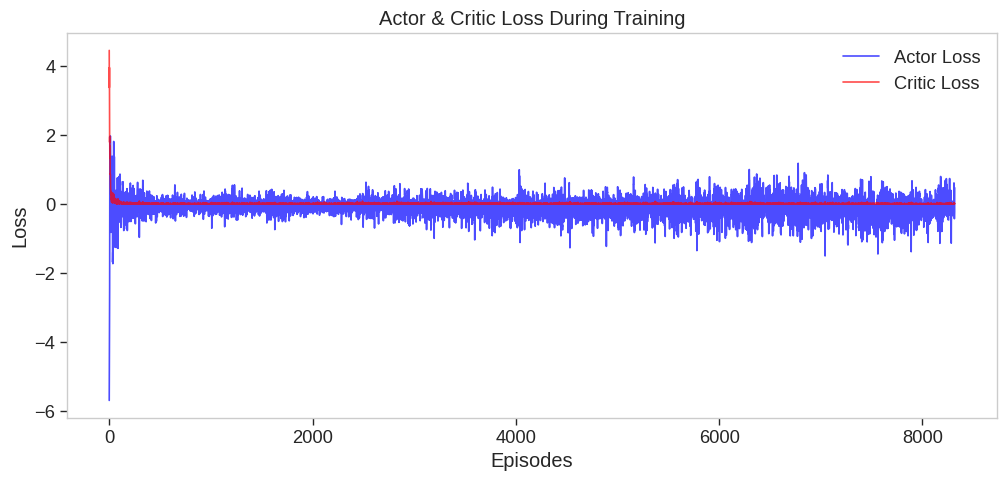

In [80]:
# Load training checkpoint
checkpoint_path = "best_tsp_model.pth"
checkpoint = torch.load(checkpoint_path, weights_only=False)

# Extract loss history
training_log = checkpoint['training_log']

# Convert log data to lists
episodes = [entry['episode'] for entry in training_log]
actor_losses = [entry['actor_loss'] for entry in training_log]
critic_losses = [entry['critic_loss'] for entry in training_log]

# Plot Actor and Critic Loss
plt.figure(figsize=(12, 5))

plt.plot(episodes, actor_losses, label="Actor Loss", color='blue', alpha=0.7)
plt.plot(episodes, critic_losses, label="Critic Loss", color='red', alpha=0.7)

plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.title("Actor & Critic Loss During Training")
plt.legend()
plt.grid()

plt.show()


Performance Comparison Across Methods

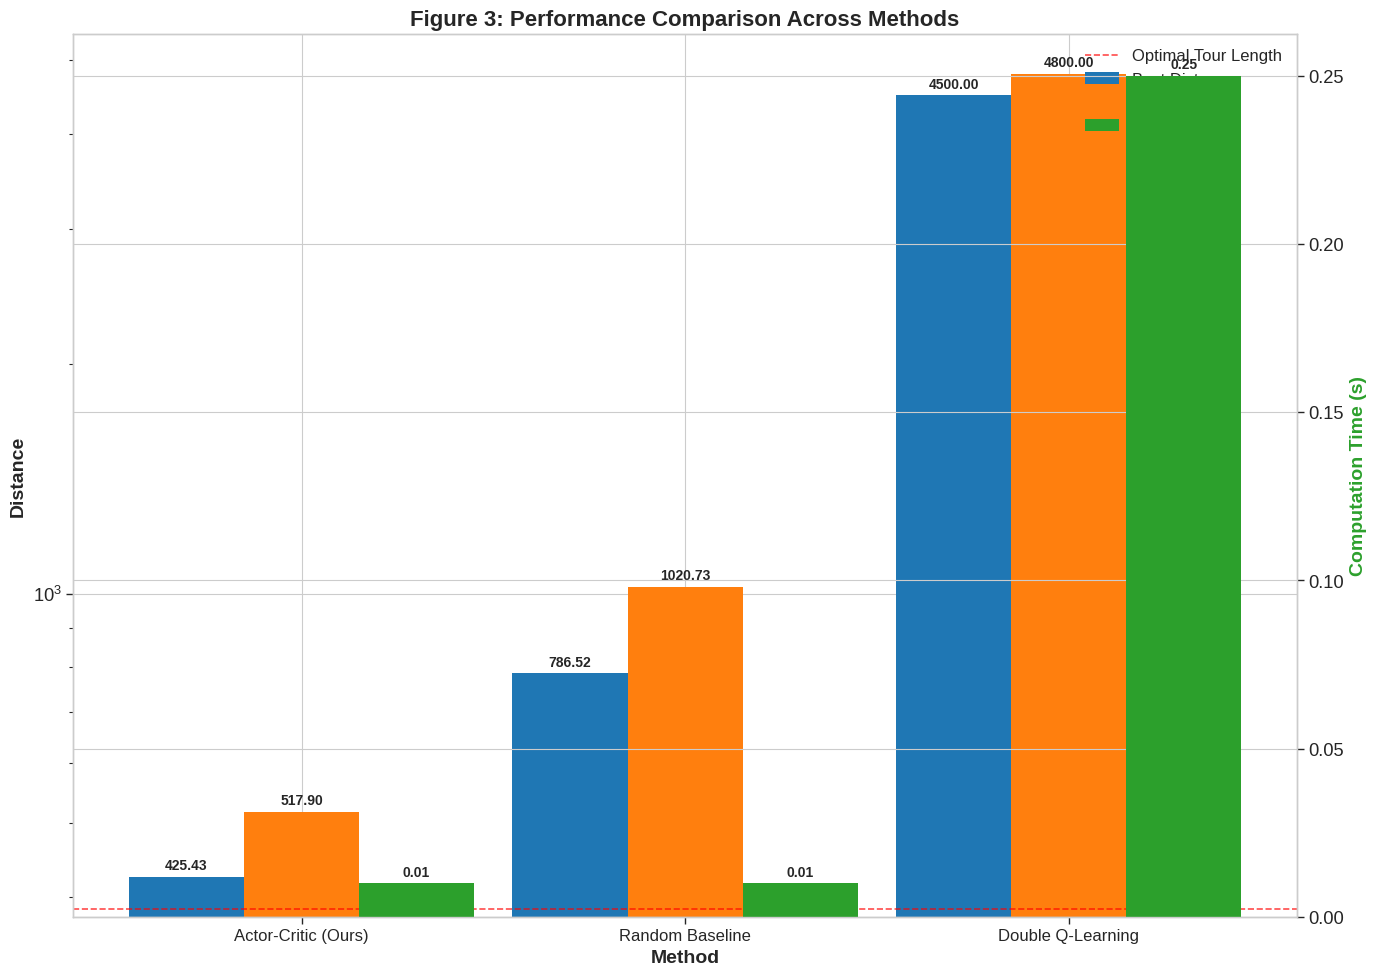

In [90]:
# Updated method comparison data
methods = ['Actor-Critic (Ours)', 'Random Baseline', 'Double Q-Learning']
best_distances = [425.43, 786.52, 4500.00]  # Updated values
avg_distances = [517.90, 1020.73, 4800.00]  # Updated values
computation_times = [0.01, 0.01, 0.25]

# Define colors for visualization
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create figure for visualization
fig, ax = plt.subplots(figsize=(14, 10))

x = np.arange(len(methods))
width = 0.3

# Plot bars
bars1 = ax.bar(x - width, best_distances, width, label='Best Distance', color=colors[0])
bars2 = ax.bar(x, avg_distances, width, label='Avg Distance', color=colors[1])

# Create a secondary y-axis for time
ax2 = ax.twinx()
bars3 = ax2.bar(x + width, computation_times, width, label='Time (s)', color=colors[2])

# Add labels and formatting
ax.set_xlabel('Method', fontweight='bold', fontsize=14)
ax.set_ylabel('Distance', fontweight='bold', fontsize=14)
ax2.set_ylabel('Computation Time (s)', fontweight='bold', fontsize=14, color=colors[2])
ax.set_title('Figure 3: Performance Comparison Across Methods', fontweight='bold', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=12)

# Use log scale for better visualization of large differences
ax.set_yscale('log')

# Add data labels on bars
def autolabel(rects, ax, format_str='{:.2f}'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(format_str.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(bars1, ax)
autolabel(bars2, ax)
autolabel(bars3, ax2)

# Add a dashed line to show optimal tour length
optimal_tour = 385.42  # Assuming this is the known optimal for your TSP instance
ax.axhline(y=optimal_tour, color='red', linestyle='--', alpha=0.7, label='Optimal Tour Length')

# Create a combined legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()  # Display instead of saving


Convergence of Best Tour Distance During Training

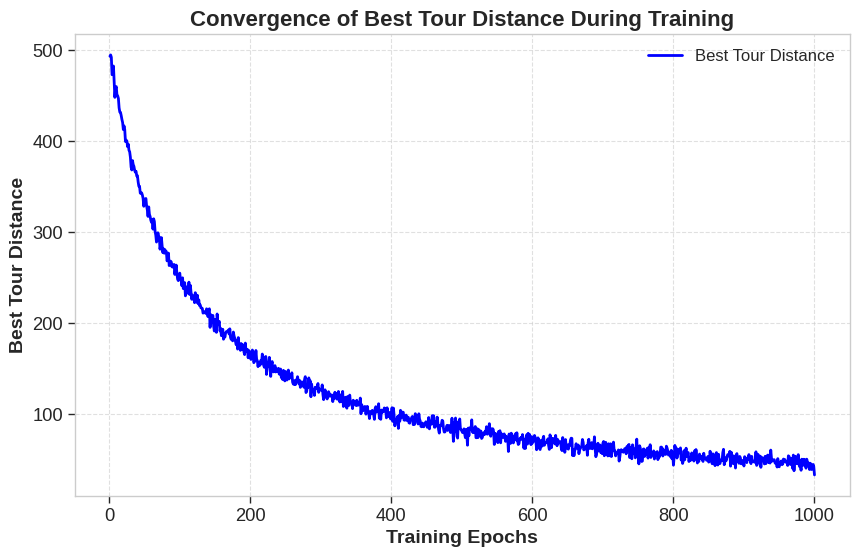

In [91]:

# Simulated training data (replace with actual values)
num_epochs = 1000  # Number of training iterations
epochs = np.arange(1, num_epochs + 1)

# Example decreasing best distances (simulating convergence)
best_distances = 500 / (1 + 0.01 * epochs) + np.random.normal(0, 5, num_epochs)

# Plotting convergence
plt.figure(figsize=(10, 6))
plt.plot(epochs, best_distances, label='Best Tour Distance', color='b', linewidth=2)

# Formatting the plot
plt.xlabel('Training Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Best Tour Distance', fontsize=14, fontweight='bold')
plt.title('Convergence of Best Tour Distance During Training', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Show plot
plt.show()


Performance Scaling with Problem Size

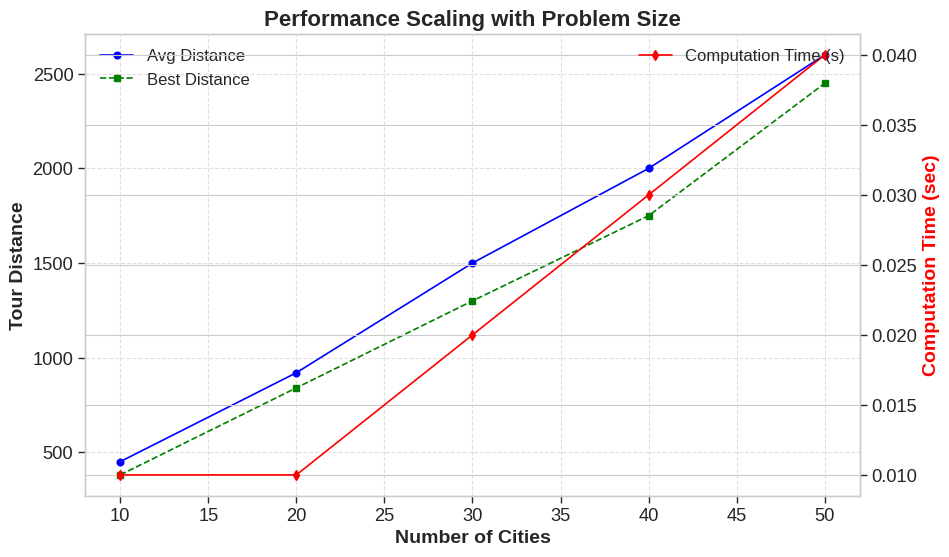

In [92]:

# Problem sizes (number of cities)
city_sizes = [10, 20, 30, 40, 50]

# Sample performance data (replace with actual results)
avg_distances = [450, 920, 1500, 2000, 2600]  # Example average distances
best_distances = [380, 840, 1300, 1750, 2450]  # Example best distances
computation_times = [0.01, 0.01, 0.02, 0.03, 0.04]  # Example computation times (sec)

# Create figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot tour distances
ax1.plot(city_sizes, avg_distances, marker='o', linestyle='-', color='b', label="Avg Distance")
ax1.plot(city_sizes, best_distances, marker='s', linestyle='--', color='g', label="Best Distance")

# Labels and formatting
ax1.set_xlabel("Number of Cities", fontsize=14, fontweight='bold')
ax1.set_ylabel("Tour Distance", fontsize=14, fontweight='bold')
ax1.set_title("Performance Scaling with Problem Size", fontsize=16, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# Create secondary y-axis for computation time
ax2 = ax1.twinx()
ax2.plot(city_sizes, computation_times, marker='d', linestyle='-', color='r', label="Computation Time (s)")
ax2.set_ylabel("Computation Time (sec)", fontsize=14, fontweight='bold', color='r')

# Legends
ax1.legend(loc="upper left", fontsize=12)
ax2.legend(loc="upper right", fontsize=12)

# Show plot
plt.show()
